## Geographical data


/home/david/miniconda3/envs/tau/lib/python3.11/site-packages/geopandas/geoseries.py:574: FutureWarning:

the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.

/home/david/miniconda3/envs/tau/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning:

The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.



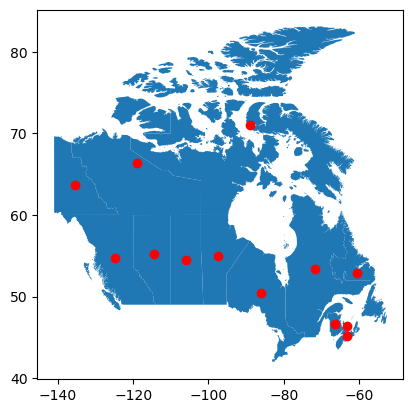

In [34]:
import geopandas as gpd

canada_gdf = gpd.read_file("data/canada/canada.geojson")
canada_gdf["centroid"]= canada_gdf["geometry"].apply(lambda x: x.centroid)
ax = canada_gdf.plot()
ax.scatter(canada_gdf["centroid"].x,canada_gdf["centroid"].y, color="red")
# this is used to get the weather data

# Batch run

In [52]:
from mesa.batchrunner import batch_run
from components.model import TechnologyAdoptionModel
from components.technologies import merge_heating_techs_with_share
import pandas as pd
from batch import (
    transform_dataframe_for_plotly,
    plotly_lines_with_error,
    transform_dict_column,
)
from batch import save_batch_parameters, read_batch_parameters, adoption_plot_with_quantiles
import plotly.graph_objects as go

heat_techs_df = merge_heating_techs_with_share()

batch_parameters = {
        "N": [200],
        "grid_side_length": [15],
        "heating_techs_df": [heat_techs_df],
        "province": ["Canada"],  # , "Alberta", "Ontario"],
        "random_seed": range(20, 28),
        "start_year": [2000],
        "interact": [False],
        "n_segregation_steps": [40]
    }


results = batch_run(
    TechnologyAdoptionModel,
    batch_parameters,
    number_processes=None,
    max_steps=80,
    data_collection_period=1,
)

  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:18<00:00,  2.29s/it]


In [53]:
df = pd.DataFrame(results)
print(len(df))
df.head()

129600


RunId  iteration  Step    N  grid_side_length  \
0      3          0     0  200                15   
1      3          0     0  200                15   
2      3          0     0  200                15   
3      3          0     0  200                15   
4      3          0     0  200                15   

                                    heating_techs_df province  random_seed  \
0  variable                     specific_fom_cost...   Canada           23   
1  variable                     specific_fom_cost...   Canada           23   
2  variable                     specific_fom_cost...   Canada           23   
3  variable                     specific_fom_cost...   Canada           23   
4  variable                     specific_fom_cost...   Canada           23   

   start_year  interact  n_segregation_steps  \
0        2000     False                   40   
1        2000     False                   40   
2        2000     False                   40   
3        2000     False                   40   
4        2000     False                   40   

                                   Technology shares  \
0  {'Electric furnace': 0.36, 'Gas furnace': 0.50...   
1  {'Electric furnace': 0.36, 'Gas furnace': 0.50...   
2  {'Electric furnace': 0.36, 'Gas furnace': 0.50...   
3  {'Electric furnace': 0.36, 'Gas furnace': 0.50...   
4  {'Electric furnace': 0.36, 'Gas furnace': 0.50...   

                           Energy demand time series  AgentID  \
0  {'Electricity': [226.9731079738805, 227.444946...        0   
1  {'Electricity': [226.9731079738805, 227.444946...        1   
2  {'Electricity': [226.9731079738805, 227.444946...        2   
3  {'Electricity': [226.9731079738805, 227.444946...        3   
4  {'Electricity': [226.9731079738805, 227.444946...        4   

                                           Attitudes  Wealth  \
0  {'Electric furnace': -0.6346870009390704, 'Gas...     0.0   
1  {'Electric furnace': -0.15224131046728973, 'Ga...     0.0   
2  {'Electric furnace': 0.6601081768058086, 'Gas ...     0.0   
3  {'Electric furnace': 0.8766810132558556, 'Gas ...     0.0   
4  {'Electric furnace': -0.4031119842660371, 'Gas...     0.0   

                 Adoption details  
0  {'tech': None, 'reason': None}  
1  {'tech': None, 'reason': None}  
2  {'tech': None, 'reason': None}  
3  {'tech': None, 'reason': None}  
4  {'tech': None, 'reason': None}

In [54]:
adoption_detail = df[["Step","RunId","Adoption details","AgentID"]]
adoption_detail.loc[:,["tech","reason"]] = pd.DataFrame.from_records(adoption_detail["Adoption details"].values)
adoption_detail = adoption_detail.drop("Adoption details", axis=1)
adoption_detail["amount"] = 1
drop_rows = adoption_detail["tech"].apply(lambda x: x is None)
adoption_detail = adoption_detail.loc[~drop_rows,:]

adoption_detail = adoption_detail.groupby(["Step","RunId","tech","reason"]).sum().reset_index()

# get cumulative sum
adoption_detail["cumulative_amount"] = adoption_detail.groupby(["RunId","tech","reason"]).cumsum()["amount"]

# fig = px.bar(adoption_detail, x="Step", y="amount", color="tech", facet_col="RunId", facet_row="reason", template="plotly") 
fig = px.area(adoption_detail, x="Step", y="cumulative_amount", color="tech", facet_col="RunId", facet_row="reason", template="plotly") 
fig.update_yaxes(matches=None)
# fig.update_layout(width=1200)

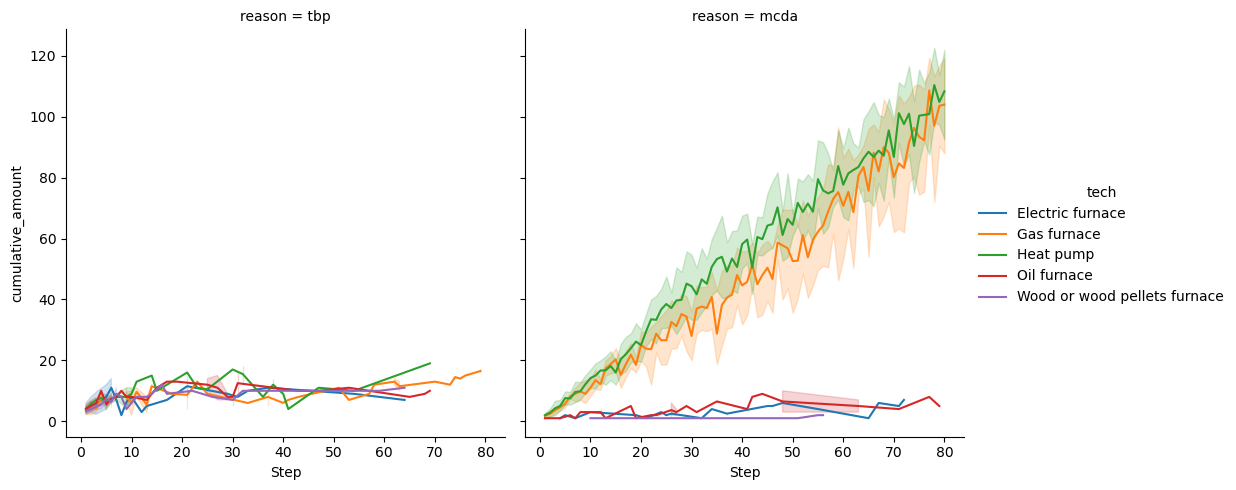

In [50]:
import seaborn as sns
sns.relplot(adoption_detail, kind="line", x="Step", y="cumulative_amount", hue="tech", col="reason")
# sns.lineplot(adoption_detail, x="Step", y="cumulative_amount", hue="tech", style="reason")

0        4
1        1
2        3
3        4
4        4
      ... 
747     74
748    107
749    126
750    132
751    122
Name: amount, Length: 752, dtype: int64

In [16]:
# adopt_details.duplicated().sum() # 15983501
# adopt_details.set_index(["year","agent_id"]).drop_duplicates() 
adopt_details.drop_duplicates() 

year reason         tech  agent_id
0      2000.00   None         None       136
1      2000.00   None         None        85
2      2000.00   None         None       123
3      2000.00   None         None        72
4      2000.00   None         None       160
...        ...    ...          ...       ...
15756  2019.50   mcda    Heat pump       170
15774  2019.50   mcda  Gas furnace       189
15810  2019.75   mcda    Heat pump        90
16028  2020.00    tbp  Oil furnace        73
16189  2020.00   mcda  Gas furnace       179

[17499 rows x 4 columns]

In [36]:

df_no_dict, columns = transform_dict_column(df, dict_col_name="Technology shares")
plotly_df = transform_dataframe_for_plotly(df_no_dict, columns, boundary_method="ci")


In [37]:

df2plot = df_no_dict[["RunId", "Step", *columns]].drop_duplicates()
df2plot = df2plot.melt(id_vars=["RunId", "Step"]).pivot(
    columns=["variable", "RunId"], index="Step", values="value"
)

# Visualising mutliple confidence intervals as shaded areas

In [38]:
import config
config.TECHNOLOGY_COLORS

{'Gas furnace': '#f7b799',
 'Oil furnace': '#f3d1bf',
 'Wood or wood pellets furnace': '#dde1f4',
 'Electric furnace': '#c4e8cb',
 'Heat pump': '#b0dbda'}

In [39]:

fig = adoption_plot_with_quantiles(df2plot, [0.68], mid_line="mean")
fig.update_layout(width=800)

In [40]:
import config
from matplotlib.colors import to_hex
import plotly.express as px
hex_colors = []
technology_colors = config.TECHNOLOGY_COLORS.copy()
for k,c in config.TECHNOLOGY_COLORS.items():
    c_hex = c
    # c_tuple = px.colors.unlabel_rgb(c)
    # c_tuple = [color/255 for color in c_tuple]
    # c_hex = to_hex(c_tuple)
    hex_colors.append(c_hex)
    technology_colors[k] = c_hex

technology_colors



{'Gas furnace': '#f7b799',
 'Oil furnace': '#f3d1bf',
 'Wood or wood pellets furnace': '#dde1f4',
 'Electric furnace': '#c4e8cb',
 'Heat pump': '#b0dbda'}

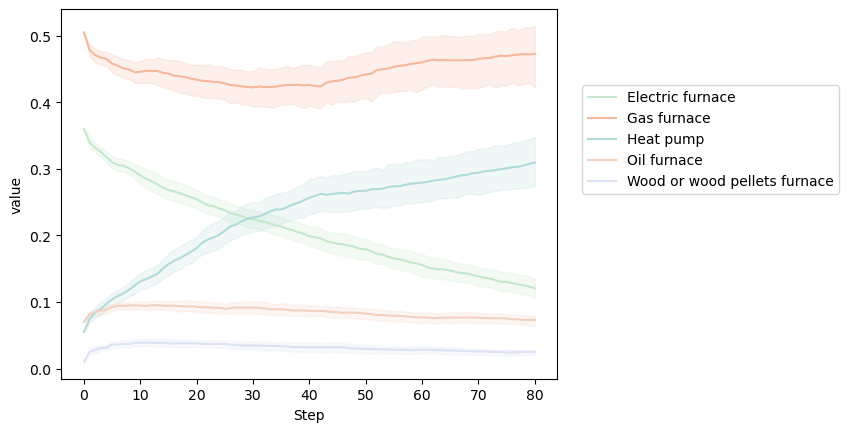

In [41]:
import seaborn as sns
df_4_plot = (
        df[["RunId", "Step", *columns]]
        .drop_duplicates()
        .melt(id_vars=["RunId", "Step"])
    )
ax = sns.lineplot(df_4_plot, x="Step", y="value", hue="variable", palette=technology_colors)
ax.legend(loc=(1.05, 0.5))

# Segregation

In [42]:
from components.model import TechnologyAdoptionModel
from components.technologies import merge_heating_techs_with_share
heating_techs = merge_heating_techs_with_share()

In [43]:
n_agents = 1000
sqr_size = int(n_agents**(1/2)) + 1
n_segregation_steps = 20

model = TechnologyAdoptionModel(n_agents, sqr_size, "Ontario", heating_techs)
income_segregation_dfs = model.perform_segregation(n_segregation_steps, capture_attribute="disposable_income")

(<Axes: >, (32, 32))

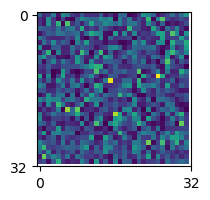

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

fig, ax = plt.subplots(figsize=(3,2))

img = income_segregation_dfs[-1].values
ax.imshow(img, label="income")
ax.set_yticks((0,img.shape[0]))
ax.set_xticks((0,img.shape[1]))
ax,img.shape,

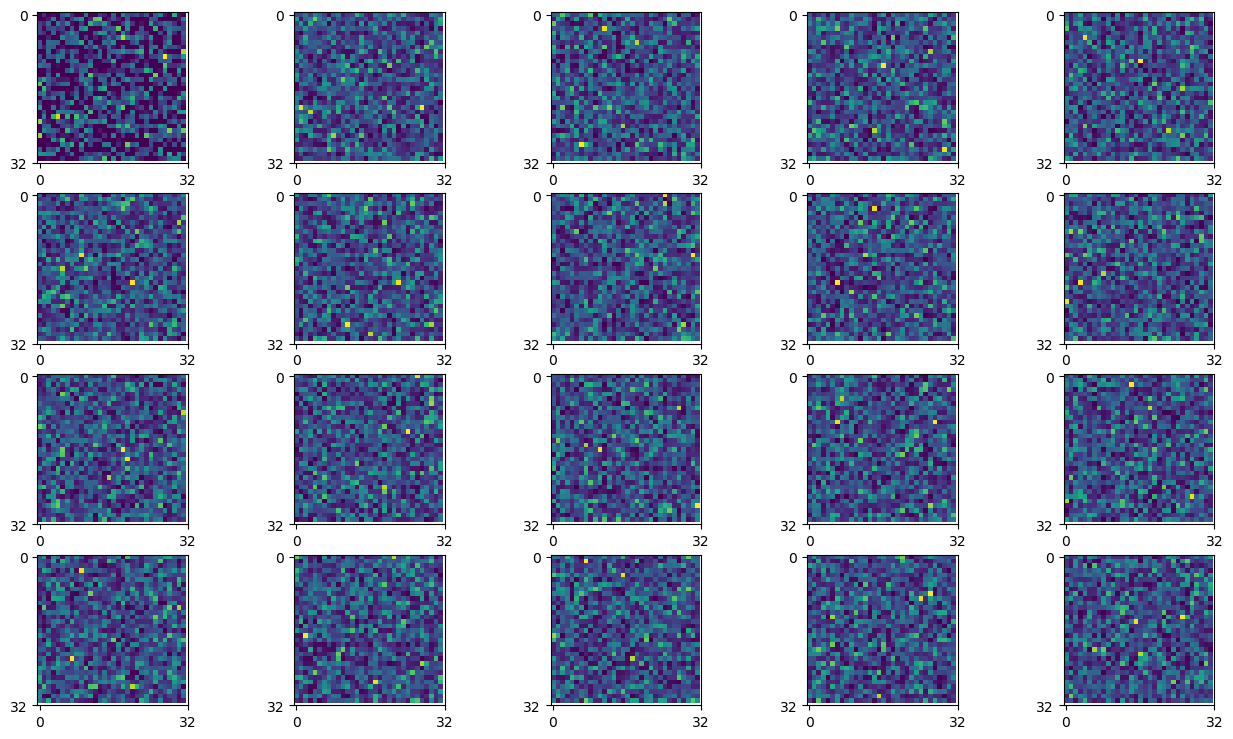

In [45]:
n_rows = int(n_segregation_steps**(1/2)) 
n_cols = n_rows +1


m_idx = list(product(range(n_rows), range(n_cols)))

fig, axes = plt.subplots(nrows=n_rows,ncols=n_cols,figsize=(16,9))

for step, income_df in enumerate(income_segregation_dfs):
    row = m_idx[step][0]
    col = m_idx[step][1]

    # values are image data
    img = income_df.values
    axes[row][col].imshow(img)

    # set ticks to only show size
    # (because the axis here, are not really relevant)
    axes[row][col].set_yticks([0,img.shape[0]])
    axes[row][col].set_xticks([0,img.shape[1]])

    # relevant_ticks = ((income_df.values.shape()))

# Parameter fit


In [56]:
from mesa.batchrunner import batch_run
from components.model import TechnologyAdoptionModel, beta_with_mode_at
from components.technologies import merge_heating_techs_with_share
from data.canada import nrcan_tech_shares_df

import plotly.express as px
import pandas as pd
import numpy as np
from batch import (
    transform_dataframe_for_plotly,
    plotly_lines_with_error,
    transform_dict_column,
    save_batch_parameters,
    read_batch_parameters,
    adoption_plot_with_quantiles,
)
import plotly.graph_objects as go
import seaborn as sns

province = "Canada"
start_year = 2000

heat_techs_df = merge_heating_techs_with_share(start_year=start_year, province=province)
historic_tech_shares = nrcan_tech_shares_df.copy()
historic_tech_shares.index = historic_tech_shares.index.swaplevel()
h_tech_shares = historic_tech_shares.loc[province,:]/100


n_steps = 80
def comparison_plot(mean_df):
    historic_tech_shares = nrcan_tech_shares_df.copy()
    historic_tech_shares.index = historic_tech_shares.index.swaplevel()
    h_tech_shares = historic_tech_shares.loc[province,:]/100

    h_tech_shares_long = h_tech_shares.melt(ignore_index=False)
    h_tech_shares_long["comparison"] = "historic"

    mean_df.long = mean_df.melt(ignore_index=False)
    mean_df.long["comparison"] = "modelled"

    comp_df = pd.concat([h_tech_shares_long,mean_df.long])
    ax = sns.lineplot(comp_df.reset_index(),x="index",hue="variable", y="value", style="comparison")
    ax.legend(loc=(1,.25))
    return ax.get_figure()

In [63]:
techs = heat_techs_df.index.to_list()
tech_mode_map = dict(zip(techs,[0.5]*len(techs)))

batch_parameters = {
    "N": [150],
    "grid_side_length": [15],
    "heating_techs_df": [heat_techs_df],
    "province": [province],  # , "Alberta", "Ontario"],
    "random_seed": range(20, 28),
    "start_year": start_year,
    "tech_attitude_dist_func":[beta_with_mode_at], 
    "tech_attitude_dist_params":[tech_mode_map],
    "n_segregation_steps" : [30],
    "interact" : [False],
}

le_dfs = []

mode_shift = 0.15
best_abs_diff = 1e12
greatest_diff_sum = None
for i in range(10):
    results = batch_run(
        TechnologyAdoptionModel,
        batch_parameters,
        number_processes=None,
        max_steps=80,
        data_collection_period=1,
    )
    df = pd.DataFrame(results)
    df_no_dict, columns = transform_dict_column(df, dict_col_name="Technology shares")
    df2plot = df_no_dict[["RunId", "Step", *columns]].drop_duplicates()
    df2plot = df2plot.melt(id_vars=["RunId", "Step"]).pivot(
        columns=["variable", "RunId"], index="Step", values="value"
    )
    
    mean_df = pd.DataFrame()
    for col in df2plot.columns.get_level_values(0).unique():
        mean_df.loc[:,col] = df2plot[col].mean(axis=1)

    mean_df.index = TechnologyAdoptionModel.steps_to_years_static(batch_parameters["start_year"],range(81),1/4)
    diff_sum = (h_tech_shares-mean_df).sum()
    
    current_abs_diff = diff_sum.abs().sum()
    print(i,current_abs_diff)
    
    if greatest_diff_sum is not None:
        if diff_sum.abs().sum() > greatest_diff_sum.abs().sum():
            greatest_diff_sum = diff_sum.copy()
    else:
        greatest_diff_sum = diff_sum.copy()


    if best_abs_diff < current_abs_diff:
        print("Performance degradation. Scaling down mode_shift")
        mode_shift = mode_shift/2
        att_update = att_update/2
        tech_mode_map = best_modes.to_dict()
    else:
        best_abs_diff = current_abs_diff
        best_modes = new_modes.copy()
        att_update = diff_sum/greatest_diff_sum.abs().max()*mode_shift
    new_modes = pd.Series(tech_mode_map) + att_update


    mean_df["iteration"] = i
    le_dfs.append(mean_df)

    new_modes[new_modes<=0] = 0.05
    new_modes[new_modes>=1] = 0.95
    debug_info = pd.concat([diff_sum.rename("diff_sum"),new_modes.rename("new_modes")], axis=1,)
    print(i,debug_info)
    tech_mode_map = new_modes.to_dict()
    batch_parameters["tech_attitude_dist_params"] = [tech_mode_map]

100%|██████████| 8/8 [00:09<00:00,  1.20s/it]


0 6.876447371114853
0                               diff_sum  new_modes
Electric furnace              2.796226   0.631868
Gas furnace                   0.641757   0.530265
Heat pump                    -3.180709   0.350000
Oil furnace                  -0.160002   0.492454
Wood or wood pellets furnace -0.097753   0.495390


100%|██████████| 8/8 [00:11<00:00,  1.48s/it]


1 3.7462661337072585
1                               diff_sum  new_modes
Electric furnace              1.872893   0.720192
Gas furnace                  -0.050743   0.527872
Heat pump                    -1.510709   0.278756
Oil furnace                  -0.275835   0.479446
Wood or wood pellets furnace -0.036086   0.493688


100%|██████████| 8/8 [00:10<00:00,  1.37s/it]


2 2.3292746147936625
2                               diff_sum  new_modes
Electric furnace              1.093726   0.771772
Gas furnace                   0.067591   0.531059
Heat pump                    -1.149876   0.224529
Oil furnace                  -0.015002   0.478739
Wood or wood pellets furnace  0.003080   0.493833


100%|██████████| 8/8 [00:10<00:00,  1.31s/it]


3 1.9364443535656564
3                               diff_sum  new_modes
Electric furnace              0.292893   0.785584
Gas furnace                   0.455091   0.552521
Heat pump                    -0.949876   0.179733
Oil furnace                   0.219998   0.489114
Wood or wood pellets furnace -0.018586   0.492957


100%|██████████| 8/8 [00:12<00:00,  1.55s/it]


4 1.1984854812662646
4                               diff_sum  new_modes
Electric furnace             -0.055440   0.782970
Gas furnace                   0.338424   0.568481
Heat pump                    -0.544042   0.154077
Oil furnace                   0.174165   0.497327
Wood or wood pellets furnace  0.086414   0.497032


100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


5 0.8609382639111318
5                               diff_sum  new_modes
Electric furnace              0.137893   0.789473
Gas furnace                   0.124257   0.574341
Heat pump                    -0.430709   0.133765
Oil furnace                   0.113332   0.502672
Wood or wood pellets furnace  0.054747   0.499614


100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


6 1.3707570265035354
Performance degradation. Scaling down mode_shift
6                               diff_sum  new_modes
Electric furnace              0.452893   0.786221
Gas furnace                  -0.334076   0.571411
Heat pump                    -0.351542   0.143921
Oil furnace                   0.171665   0.500000
Wood or wood pellets furnace  0.060580   0.498323


100%|██████████| 8/8 [00:10<00:00,  1.34s/it]


7 0.7842715972444647
7                               diff_sum  new_modes
Electric furnace              0.242893   0.791949
Gas furnace                   0.010091   0.571649
Heat pump                    -0.392376   0.134669
Oil furnace                   0.095832   0.502259
Wood or wood pellets furnace  0.043080   0.499339


100%|██████████| 8/8 [00:11<00:00,  1.44s/it]


8 1.2957570265035354
Performance degradation. Scaling down mode_shift
8                               diff_sum  new_modes
Electric furnace              0.354560   0.789085
Gas furnace                  -0.266576   0.571530
Heat pump                    -0.381542   0.139295
Oil furnace                   0.243332   0.501129
Wood or wood pellets furnace  0.049747   0.498831


100%|██████████| 8/8 [00:11<00:00,  1.41s/it]


9 1.1574236931702022
Performance degradation. Scaling down mode_shift
9                               diff_sum  new_modes
Electric furnace              0.367893   0.787653
Gas furnace                  -0.106576   0.571470
Heat pump                    -0.472376   0.141608
Oil furnace                   0.139998   0.500565
Wood or wood pellets furnace  0.070580   0.498577


In [59]:
l_hist_shares = historic_tech_shares.loc[province,:].melt(ignore_index=False).reset_index()
l_hist_shares["iteration"] = "historic"
l_hist_shares["value"] *= 0.01

In [62]:
def parameter_fit_results(dfs: list[pd.DataFrame]):
    results = pd.concat(dfs)
    results.reset_index(names=["year"], inplace=True)
    long_results = results.melt(id_vars=["year","iteration"])
    return long_results

pfit_res = parameter_fit_results(le_dfs)
pfit_res_historic = pd.concat( [pfit_res, l_hist_shares])

fig = px.line(pfit_res, x="year", y="value", color="variable", line_dash="iteration", template="plotly", )

def update_trace_opacity(trace: go.Trace):
    # TODO: add this variable in loop above
    n_fit_iterations = 10
    iteration = trace.name.split(",")[-1]
    if iteration == " historic":
        opacity = 1
    else:
        opacity = int(iteration) * 1/n_fit_iterations

    trace.opacity = opacity


fig.for_each_trace(lambda t: update_trace_opacity(t))

for i,tech in enumerate(historic_tech_shares.loc[province,:].columns):
    fig.add_trace(
        go.Scatter(
            x=historic_tech_shares.loc[province,tech].index,
            y=historic_tech_shares.loc[province,tech].values/100,
            mode="lines",
            name=f"{tech}, historic",
            line=dict(dash="solid", width=3, color=px.colors.qualitative.Plotly[i]),
        )
    )

fig.update_layout(width=800)

## Draw dependent random parameters (mcda weights)

weights for mcda need to be diverse across agents, and have to add up to 1.
This can be achieved, by drawing one weight $w_0$ from an assumed distribution D between 0 and 1, and then drawing $w_i$ from the same distribution with adapted boundaries as $1 - w_0$ for the upper bound. More formally, the equation for the upper bound of $w_i$ is:
$$ 1- \sum_{i-1} w_{i-1} $$



In [52]:
# from scipy.stats import beta
# from scipy.optimize import curve_fit
# from ipywidgets import interact

# normed_income_freq = canada_income["VALUE"]/canada_income["VALUE"].sum()
# normed_income_bins = canada_income["Mean income"]/canada_income["Mean income"].sum()

# def fit_beta(a, b):
#     x = np.linspace(0, 1, 100)
#     y = beta.pdf(x, a, b)
#     y = y / y.max() * normed_income_freq.max()
#     ax = plt.pyplot.plot(x, y, label="beta fit")
#     plt.pyplot.plot(canada_income["Mean income"]/canada_income["Mean income"].max(),normed_income_freq)
#     return ax

# x = np.linspace(0, 1, 100)
# def scaled_beta(x, a, b):
#     y = beta.pdf(x, a, b)
#     y = y / y.max() * normed_income_freq.max() 
#     return y
    

# p,v = curve_fit(scaled_beta, normed_income_bins, normed_income_freq, p0=(2, 2))

# # interact(fit_beta, a=(0.5, 10.), b=(0.5, 10.))

# p

In [65]:
from components.model import get_income_and_attitude_weights

all_dfs = []
for p_mode in [0.5, 0.7, 0.9]:
    _, weights_df = get_income_and_attitude_weights(1000, price_weight_mode=p_mode)
    weights_df["mode"] = p_mode
    # print(weights_df.head())
    all_dfs.append(weights_df.copy())

all_df = pd.concat(all_dfs)

fig = px.histogram(
    all_df.melt(id_vars=["mode"]),
    facet_col="variable",
    facet_row="mode",
    category_orders={
        "variable": ["cost_norm", "emissions_norm", "attitude"],
        "mode": [0.5, 0.7, 0.9][::-1],
    },
)
fig.update_layout(template="plotly", xaxis_title="test", width=800)

In [66]:
_, w_df = get_income_and_attitude_weights(100)
(w_df.sum(axis=1) == 1.0).sum()

100

## parameter fit for mcda-weight's mode

In [72]:
# new_modes
# Electric furnace                0.766605
# Gas furnace                     0.504180
# Heat pump                       0.146975
# Oil furnace                     0.568051
# Wood or wood pellets furnace    0.514014

Electric furnace                0.766605
Gas furnace                     0.504180
Heat pump                       0.146975
Oil furnace                     0.568051
Wood or wood pellets furnace    0.514014
dtype: float64

In [70]:
from batch import transform_dict_column
province = "Canada"
start_year = 2000
heat_techs_df = merge_heating_techs_with_share(start_year=start_year, province=province)

batch_parameters = {
    "N": [150],
    "grid_side_length": [15],
    "heating_techs_df": [heat_techs_df],
    "province": [province],  # , "Alberta", "Ontario"],
    "random_seed": range(20, 28),
    "start_year": start_year,
    "tech_attitude_dist_func":[beta_with_mode_at], 
    "tech_attitude_dist_params":[best_modes.to_dict()],
    "n_segregation_steps": [30],
    "interact": [False],
}

adoption_dfs = []
for p_mode in [0.9, 0.8, 0.7, 0.6]:
    
    # # single model run
    # model = TechnologyAdoptionModel(100, 11, province, heat_techs_df, price_weight_mode=p_mode, tech_attitude_dist_params=new_modes.to_dict(), tech_attitude_dist_func=beta_with_mode_at)
    # for i in range(80):
    #     model.step()

    # model_vars = model.datacollector.get_model_vars_dataframe()
    # adoption_df = transform_dict_column(model_vars[["Technology shares"]], return_cols=False)
    # adoption_df.index = model.get_steps_as_years()
    # adoption_df["p_mode"] = p_mode
    # adoption_dfs.append(adoption_df)

    # diff_sum = (h_tech_shares-adoption_df).sum()    
    batch_parameters["price_weight_mode"] = p_mode

    results = batch_run(
        TechnologyAdoptionModel,
        batch_parameters,
        number_processes=None,
        max_steps=80,
        data_collection_period=1,
    )
    df = pd.DataFrame(results)
    df_no_dict, columns = transform_dict_column(df, dict_col_name="Technology shares")
    df2plot = df_no_dict[["RunId", "Step", *columns]].drop_duplicates()
    df2plot = df2plot.melt(id_vars=["RunId", "Step"]).pivot(
        columns=["variable", "RunId"], index="Step", values="value"
    )
    
    mean_df = pd.DataFrame()
    for col in df2plot.columns.get_level_values(0).unique():
        mean_df.loc[:,col] = df2plot[col].mean(axis=1)

    mean_df.index = TechnologyAdoptionModel.steps_to_years_static(batch_parameters["start_year"],range(81),1/4)
    mean_df["p_mode"] = p_mode
    adoption_dfs.append(mean_df)
    diff_sum = (h_tech_shares-mean_df).sum()

    
    total_abs_diff = diff_sum.abs().sum()
    print(p_mode,total_abs_diff)
    # print(f"finished iteration {i}")

mcda_fit_results = pd.concat(adoption_dfs)



  0%|          | 0/8 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:10<00:00,  1.29s/it]


0.9 1.6474236931702024


100%|██████████| 8/8 [00:10<00:00,  1.28s/it]


0.8 1.372423693170202


100%|██████████| 8/8 [00:12<00:00,  1.50s/it]


0.7 1.6092715972444651


100%|██████████| 8/8 [00:11<00:00,  1.47s/it]


0.6 2.3151521479329316


In [72]:
fit_results_long = mcda_fit_results.melt(ignore_index=False, id_vars=["p_mode"]).reset_index()
fit_results_long["value"] *= 100
fig = px.line(fit_results_long, x="index", y="value", color="variable", line_dash="p_mode", template="plotly")
for i,tech in enumerate(historic_tech_shares.loc[province,:].columns):
    fig.add_trace(
        go.Scatter(
            x=historic_tech_shares.loc[province,tech].index,
            y=historic_tech_shares.loc[province,tech].values,
            mode="lines",
            name=f"{tech}, historic",
            line=dict(dash="solid", width=3, color=px.colors.qualitative.Plotly[i]),
        )
    )
fig.update_layout(yaxis_title="Market share (%)", xaxis_title="Time", title=f"Technology shares in {province}", width=800)

legend_traces = [
    px.line(
        fit_results_long,
        x="index",
        y=np.full(len(fit_results_long), -1000),
        **param["px"],
        template="plotly"
    ).update_traces(**param["lg"], legendgroup=str(param["px"]))
    for param in [
        {"px": {"color": "variable"}, "lg": {"legendgrouptitle_text": "Heating appliance"}},
        # {"px": {"symbol": "Device"}, "lg": {"legendgrouptitle_text": "Device"}},
        {"px": {"line_dash": "p_mode"}, "lg": {"legendgrouptitle_text": "p_mode"},
        },
    ]
]
for t in legend_traces:
    fig.add_traces(t.data)
# hide the dummy traces for extra legend entries (given y-value of -1000)
fig.update_yaxes(range=[0, fit_results_long["value"].max()])

In [62]:
from data.canada import tech_capex_df
from components.technologies import is_num

capex_df = tech_capex_df#.reset_index()
keep = capex_df["Heat pump"].apply(is_num)
avg_prices = capex_df.loc[keep,:].astype(float).reset_index().groupby("variable").mean().drop("year", axis=1)


avg_prices

Electric furnace  Gas furnace  Heat pump  Oil furnace  \
variable                                                                        
efficiency                          1.00        0.900      3.000        0.900   
lifetime                           20.00       20.000     15.000       30.000   
specific_cost                      81.81      181.400    794.364      185.386   
specific_fom_cost                   3.17        3.664     14.202        5.608   
specific_fuel_emission              0.40        0.200      0.400        0.500   

                        Wood or wood pellets furnace  
variable                                              
efficiency                                     0.800  
lifetime                                      20.000  
specific_cost                                460.894  
specific_fom_cost                             26.740  
specific_fuel_emission                         0.150

In [50]:
diff_sum = (h_tech_shares-adoption_df).sum()


In [45]:
adoption_df

Electric furnace  Gas furnace  Heat pump  Oil furnace  \
0               0.31         0.52       0.04         0.11   
1               0.29         0.50       0.08         0.10   
2               0.29         0.49       0.09         0.10   
3               0.28         0.48       0.10         0.10   
4               0.28         0.47       0.10         0.11   
..               ...          ...        ...          ...   
75              0.12         0.59       0.19         0.07   
76              0.12         0.60       0.18         0.07   
77              0.12         0.60       0.18         0.07   
78              0.12         0.60       0.18         0.07   
79              0.12         0.60       0.17         0.08   

    Wood or wood pellets furnace  
0                           0.02  
1                           0.03  
2                           0.03  
3                           0.04  
4                           0.04  
..                           ...  
75                          0.03  
76                          0.03  
77                          0.03  
78                          0.03  
79                          0.03  

[80 rows x 5 columns]

# track adoption details


In [1]:
from components.technologies import merge_heating_techs_with_share
from components.model import TechnologyAdoptionModel


heating_techs_df = merge_heating_techs_with_share()
model = TechnologyAdoptionModel(
    100, 11, "Canada", heating_techs_df, start_year=2000, random_seed=123
)

for _ in range(80):
    model.step()

In [3]:

final_df = model.get_adoption_details()
px.bar(final_df, x="step", y="value", color="tech", facet_row="reason", template='plotly')


In [7]:
total_adopted_appliances_count = final_df.reason.value_counts()
adoption_reason_share =total_adopted_appliances_count/total_adopted_appliances_count.sum()
adoption_reason_share

reason
mcda    0.8125
tpb     0.1875
Name: count, dtype: float64

<Axes: xlabel='tech', ylabel='age'>

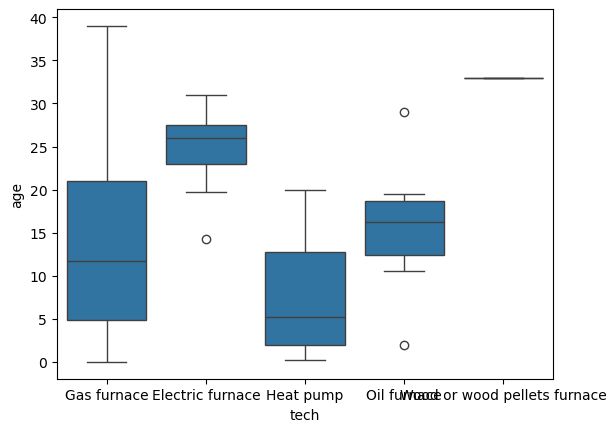

In [65]:
import seaborn as sns
techs = []
for a in model.schedule.agents:
    techs.append((a.heating_tech.name, a.heating_tech.age))

df = pd.DataFrame.from_records(techs, columns=["tech", "age"])
sns.boxplot(df, x="tech",y="age")

Text(0.5, 0, 'number of adopted appliances')

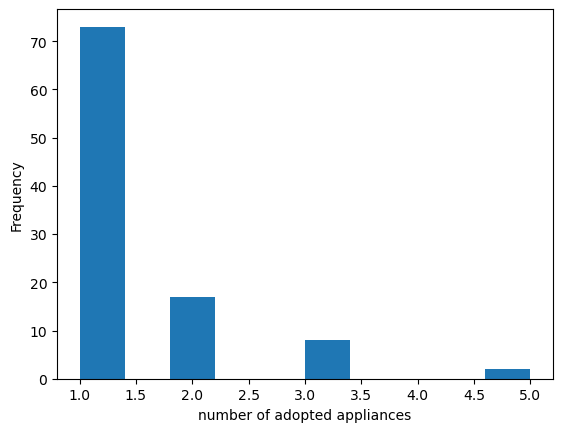

In [ ]:
adoption_counts = df["agent_id"].value_counts()

heaviest_adopters = adoption_counts.iloc[:3].index.to_list()
ax = adoption_counts.reset_index(drop=True).plot(kind="hist")
ax.set_xlabel("number of adopted appliances")

In [ ]:
df["tpb_tech"].value_counts(), df["mcda_tech"].value_counts()

(tpb_tech
 Gas furnace         11
 Heat pump            9
 Electric furnace     6
 Oil furnace          5
 Name: count, dtype: int64,
 mcda_tech
 Gas furnace         62
 Heat pump           44
 Electric furnace     4
 Name: count, dtype: int64)